In [1]:
#import 
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import Angle
import glob
import os
from scipy.stats import scoreatpercentile
import astropy.units as u
from scipy import stats
from astropy.visualization import (MinMaxInterval, LogStretch, ImageNormalize)
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors


from astropy.nddata import CCDData
#from ccdproc import ImageFileCollection, Combiner, combine
#from ccdproc import wcs_project

### Some functions to display the images and overplot the stars

In [2]:
def imdisplay(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(v1,v2)
    if (logscale):
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        
    cbar = fig.colorbar(im, ax=ax, fraction=0.04)
    cbar.ax.set_ylabel('counts')
    return fig,ax
    #fig.colorbar(fraction=.08)

In [3]:
#***************
#Set the home path
os.environ['HOME'] ='C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir+'/Virgo/tables'
plotdir = homedir+'/Virgo/plots'
datadir = homedir+'/HerschelGalaxyPhotometry'
os.chdir(datadir)

## Display the image in DS9

SAOimage DS9 is a popular and easy to use image viewer.  There are various tutorials at https://sites.google.com/cfa.harvard.edu/saoimageds9/documentation?authuser=0 .

Here is another third party tutorial https://astrobites.org/2011/03/09/how-to-use-sao-ds9-to-examine-astronomical-images/ 

In the following description I will refer to menu choices as those at the top of the screen or window.  I will refer to buttons as the double line of buttons right above where the image is displayed.  I will refer to sub buttons with **button1**->**button2**

1. In DS9 open `NGC3982-custom-image-r.fits`
2. Under the **scale** button choose **log** and **zscale**.  In the Menu bar choose Scale->Scale parameters.  In the "high" box choose 3.
3. Use the right mouse button to change the stretch on the image.  You may need to select the **edit**->**none** or **edit**->**colorbar** button for this to work.


In [4]:
imname = datadir+'/NGC5055/UnimapRed/red.gz'
data,header = fits.getdata(imname, header=True)
test = fits.open(imname)

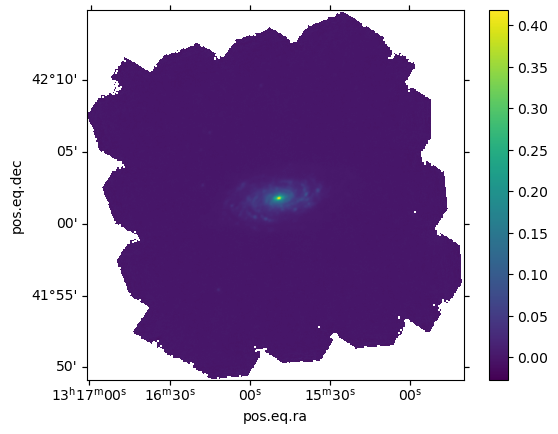

In [5]:
wcs = WCS(header)
ax = plt.subplot(projection=wcs)
im = ax.imshow(data)
plt.colorbar(im)

In [18]:
def measure_phot(data):
        '''
        # rmax is max radius to measure ellipse
        # could cut this off based on SNR
        # or could cut this off based on enclosed flux?
        # or could cut off based on image dimension, and do the cutting afterward
        
        #rmax = 2.5*self.sma
        '''
        # rmax is set according to the image dimensions
        # look for where the semi-major axis hits the edge of the image
        # could by on side (limited by x range) or on top/bottom (limited by y range)
        # 
        yimage_max, ximage_max = data.shape
        
        rmax = np.min([(ximage_max - x0)/abs(np.cos(PAN)),\
                        (yimage_max - y0)/abs(np.sin(PAN))])
        index = np.arange(80)
        apertures = (index+1)*.5*.5*(1+(index+1)*.1)
        # cut off apertures at edge of image
        apertures_a = apertures[apertures < rmax]
        apertures_b = (1.-EPLI)*apertures_a
        area = np.pi*apertures_a*apertures_b # area of each ellipse

        flux1 = np.zeros(len(apertures_a),'f')
        sflux1_err = np.zeros(len(apertures_a),'f')
        allellipses = []
        for i in range(len(apertures_a)):
            # EllipticalAperture takes rotation angle in radians, CCW from +x axis
            ap = EllipticalAperture((x0, y0),apertures_a[i],apertures_b[i],PAN)#,ai,bi,theta) for ai,bi in zip(a,b)]
            allellipses.append(ap)
                    # subpixel is the method used by Source Extractor
            phot_table1 = aperture_photometry(data, ap, method = 'subpixel', 
                                                    subpixels=5)
            
            flux1[i] = phot_table1['aperture_sum'][0]
            if np.isnan(flux1[i]):
                break
        # first aperture is calculated differently
        sb1 = np.zeros(len(apertures_a),'f')
        sb1_err = np.zeros(len(apertures_a),'f')

        sb1[0] = flux1[0]/area[0]
        # outer apertures need flux from inner aperture subtracted
        for i in range(1,len(area)):
            sb1[i] = (flux1[i] - flux1[i-1])/(area[i]-area[i-1])    
        valid_indices = ~np.isnan(sb1) & ~np.isnan(flux1) & (sb1 != 0) & (flux1 != 0)
        sb1 = sb1[valid_indices]
        flux1 = flux1[valid_indices]
        apertures_a = apertures_a[valid_indices]
        print('Number of apertures = ',len(apertures_a))
        return sb1, flux1, apertures_a

In [14]:
#testing wcs transformation
ra = 108
dec = 72
ra2, dec2 = wcs.all_world2pix(ra, dec, 0)
ra2, dec2

(array(31710.23630057), array(72533.62470103))

This is a code that will take in an image name and data, as well as corners of background boxes, and will measure the background in two different ways.


Open the image in ds9 and use the log stretch to see if you can define corners of the image that are relatively free of galaxy light at a hard stretch.  You will compute the average pixel value in each of these regions and take the average.  It is ok if there are stars in these regions.  You should have 4 regions for the image.  An example that works for this image is shown below.  

**Note**
* to make it simpler, the boxes should be equal in size.  You will need to specify the lower left corner of each box.
* The images I am providing here have been selected from much larger images from the DESI Legacy Survey https://www.legacysurvey.org/viewer .  Therefore they do not have strange behavior around the edges and you can use the edges of the image as the edges of your sky region without any buffer region.

To make your coding easier, I'm going to make a bunch of dictionaries such that the main variable name is the same and you only have to change the galaxy name with the galname variable.

**Question**: comment on the differences between the images with background and those with background subtracted.  Please describe why you think this is.

put answer here.

## Problem 2 - estimate initial guesses for ellipse parameters (15 Points)
The `photutils` package that we will be using for doing our photometry requires initial guesses for the center, semi-major axis, ellipticity, and position angle.  We will measure these using DS9 on the background subtracted images.
* xcen, ycen: What you think the center is by using the cursor on ds9

* semi-major axis, ellipticity, PA: For the other items you will need to make an elliptical region in ds9 that matches where the brighter part of the galaxy is.  If you double click on the region it will bring up a dialog box that lets you adjust the PA and also will output the semi-major and semi-minor axes, which you will need for the ellipticity measurement.  You should display the information in pixels using the dropdown to the right of the `radius` field in the "Ellipse" window.  Choose `Image`

**Note**: In ds9, when the first radius in the `Ellipse` window is the semi-major axis, the PA is measured South of East.  This is the same sense as the Elliptical Isophote package in the following problem uses.

For each galaxy, provide these intial guesses.  I will be storing these as a python dictionary for each galaxy.

These guesses do not need to be super precise but they need to be in the right ballpark.

In [15]:
#initialize the dictionary containing the intial parameters for the ellipse fitting
initparams = {}

#### NGC 5055

In [16]:
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'UGC03701'
initparams[galname] = {}
initparams[galname]['xcen'] = 1861
initparams[galname]['ycen'] = 1862
initparams[galname]['sma'] = 433
initparams[galname]['ellip'] = 0.574
initparams[galname]['PA'] = 98

## Problem 3 - fit elliptical isophotes and measure the radial profiles for various ellipse paramters (15 Points)

We will now use the `photutils.isophot()` task to fit elliptical isophotes (https://photutils.readthedocs.io/en/stable/isophote.html).  An "isophote" is a line of constant surface brightness, akin to a countour on a topographical map.  To get a visual representation of an isophote do the following:
* open one of the background subtracted images in ds9 and dislay it in log scale
* in the analysis menu open "contour parameters" and set the number of countours to 10.  Then hit `Generate` and then `Apply`

The green lines on your image connect pixels of identical flux.  Since the pixels have the same area within a given image, these lines therefore connect points of constant surface brightness.

The `photutils.isophote()` code that we will be using fits ellipses to the isophotes.

In [7]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.aperture import aperture_photometry
#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}

 We must provide the elliptical isophote fitter with an initial ellipse to be fitted. This ellipse geometry is defined with the **EllipseGeometry** class. Here we’ll define an initial ellipse from our answer to problem 2.

### NGC 3982

1.906627672724431e-05 0.0037011535838246375


(<matplotlib.patches.Ellipse at 0x181d703ab90>,)

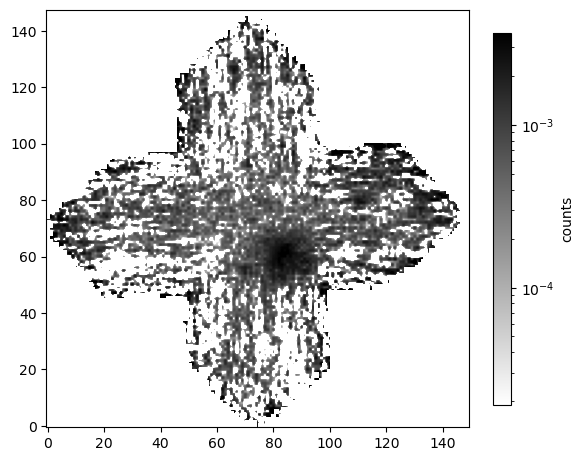

In [8]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'UGC03701'
geometry[galname] = EllipseGeometry(x0 = 250, 
                                      y0 = 240,
                                      sma = 35.45,
                                      eps = 0.574,
                                      pa = 8 * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
imname = datadir+'/UGC03701/UnimapRed/red.gz'
data,header = fits.getdata(imname, header=True)
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data,v1perc=17,v2perc=46,logscale=True)
aper.plot(color='red')

In [19]:
x0 = 82
y0 = 60
PAN = 4.210212705195 * np.pi/180
EPLI = 0.919577121734619
measure_phot(data)

Number of apertures =  42


(array([0.02092075, 0.00370903, 0.00174867, 0.00204643, 0.00265567,
        0.00456695, 0.00279335, 0.00169794, 0.00389533, 0.00221018,
        0.00262698, 0.00219883, 0.00226013, 0.00219226, 0.00194553,
        0.00193796, 0.00171271, 0.00144056, 0.00149679, 0.00118653,
        0.00111857, 0.00115956, 0.00103178, 0.00090957, 0.00080462,
        0.00078621, 0.00068724, 0.00056559, 0.00065563, 0.00060005,
        0.00058521, 0.00056971, 0.00058119, 0.00057476, 0.0004981 ,
        0.00050433, 0.00049686, 0.00046459, 0.0004506 , 0.00054429,
        0.00041387, 0.00031757], dtype=float32),
 array([3.99734970e-04, 6.66224980e-04, 9.27169807e-04, 1.44905946e-03,
        2.49283900e-03, 5.08255046e-03, 7.26377778e-03, 9.02667269e-03,
        1.42581966e-02, 1.80131923e-02, 2.35556774e-02, 2.92274747e-02,
        3.62601206e-02, 4.43936251e-02, 5.29124811e-02, 6.28371015e-02,
        7.30129182e-02, 8.28706920e-02, 9.45904702e-02, 1.05157666e-01,
        1.16427094e-01, 1.29576847e-01, 1.42686

make a subroutine to plot our outputs of ellipse fitting

In [15]:
def plotellipse(isolist):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.35, wspace=0.35)

    #plot the semi-major axis vs. the ellipticity
    plt.subplot(2, 2, 1)
    plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('Ellipticity')

    #plot the semi-major axis vs. the PA
    plt.subplot(2, 2, 2)
    plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0,
                 yerr=isolist.pa_err / np.pi * 80.0, fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('PA (deg)')

    #plot the semi-major axis vs. the x center of that ellipse
    plt.subplot(2, 2, 3)
    plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('x0')

    #plot the semi-major axis vs. the y center of that ellipse
    plt.subplot(2, 2, 4)
    plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('y0')

Next, we create an instance of the Ellipse class, inputting the data to be fitted and the initial ellipse geometry object:

In [16]:
from photutils.isophote import Ellipse

#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}

The values computed by the fitting process are the attributes at this table https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Isophote.html#photutils.isophote.Isophote

I will do the first galaxy for you and you will need to do the other three

### NGC 5055

In [17]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC5055'
ellipse[galname] = Ellipse(data, geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\USER\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


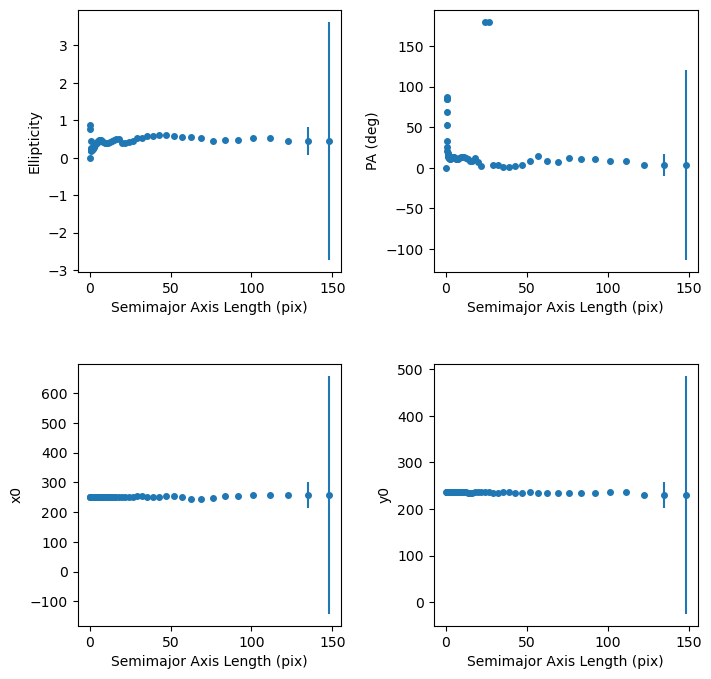

In [18]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
#print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

**put answer in this cell**

## Problem 4 - measure the half light radius (15 points)

To do this we will create something called a "curve of growth", which shows how much light you get within each aperture.  As you increase in radius this cumulative flux grows.



In [19]:
#initialize dictionary for half-light radii
rhalfpix = {}
rhalfasec = {}

### NGC 3982

flux of largest isophote =  261.714511996659
the half-light radius = 124.800 [asec]


Text(0.5, 1.0, 'NGC5055')

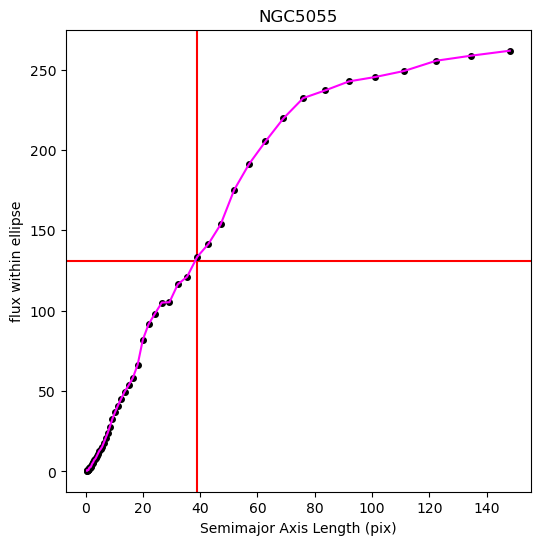

In [27]:
galname = 'NGC5055'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 39.
plt.axvline(rhalfpix[galname], color='red')

#The pixel scale from the header converted from degrees to asec
pixscale = header['CDELT2'] * 3600.    #in asec/pix
#***************************
#Your code here
#*******************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this.
rhalfasec[galname] = rhalfpix[galname] * pixscale
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


**Question** If the goal of measuring the half-light radius is to obtain light from the galaxy.  What do you think you can do in order to minimize the effect of other sources in the image on this measurment.  

**put answer here**

## Problem 5 - construct radial surface brightness profiles (15 Points)

In this problem you will construct radial surface brightness profiles of each galaxy and use them to infer the central surface brightness and that at the half-light radius.

For the purpose of these plots, we will fix the ellipticity and position angle at the values determined at the half-light radius.

You will need to:
* measure mean surface brightness in mag/asec^2 in each annulus
* calculate its uncertainty
* plot the surface brightness profile
* determine the surface brightness at the half-light radius

In [24]:
from photutils.aperture import ApertureStats
from photutils.aperture import EllipticalAnnulus, EllipticalAperture

### NGC 3982

In [25]:
galname = 'NGC5055'

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2']    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area
        
        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, 1.086 * (avflux_err / avflux))

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
print(f'r = {rcent[30]:.3f} [asec]; surface brightness at r = {sbcent[30]:.3f}')

#calculate print out the surface brightness at the effective radius
#***********************
#your code here
print(f'r = {rcent[rhalfpixind]:.3f} [asec]; surface brightness at r = {sbcent[rhalfpixind]:.3f}')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = 10**(-0.4 * (sbcent[rhalfpixind] - sbcent[30]))
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


KeyError: "Keyword 'NGC5055' not found."

**Question** Describe the ratio in surface brightness between the center and outskirts including the following points:
* Are there differences between ellipticals and spirals?
* Does the degree to which your galaxy is well resolved matter?
* Does the behavior of the light profile differ inside and outside of the half-light radius?  
* which galaxies have light profiles consistent with being exponential, and in what part of the profiles

**answer goes here**